### Bibliotecas

In [1]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio
import numpy as np
from pyproj import CRS
from rasterio.mask import mask
import matplotlib.patches as mpatches
import matplotlib.dates as mdates

### Parâmetros

In [2]:
diretorio_raiz = '/Volumes/MiniArmstro/Resultados/Processamento'
subprefeitura_desejada = "LAPA"
diretório_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023'
pacotes = '/Users/marcelofernandes/PycharmProjects/SP_urban_flooding/pacotes.simul_2023_1120.xls'
raster_poligono_chuva = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/Rain_mask_Sao_Paulo.tif'
subprefeituras_shp = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/SIRGAS_SHP_subprefeitura/SIRGAS_SHP_subprefeitura_polygon.shp'
zonas_shp_OD_2023 = '/Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/PESQUISA_ORIGEM_E_DESTINO_2023_anexos/002_Site Metro Mapas/Shape/Zonas_2023.shp'
verbose = True


### Concatenando os arquivos

In [3]:
# Regex para capturar informações do nome do arquivo
padrao = re.compile(r"df_result_resiliencia_(\w+)_Pacote_(\d+)_Pacote_\d+\.csv")

# Lista os arquivos e filtra os da subprefeitura desejada
arquivos = []
for nome_arquivo in os.listdir(diretorio_raiz):
    match = padrao.match(nome_arquivo)
    if match and match.group(1).upper() == subprefeitura_desejada.upper():
        primeiro_pacote = int(match.group(2))
        arquivos.append((primeiro_pacote, nome_arquivo))

# Ordena os arquivos pelo número do primeiro pacote
arquivos_ordenados = sorted(arquivos, key=lambda x: x[0])

# Junta todos os DataFrames
df_concatenado = pd.concat([
    pd.read_csv(os.path.join(diretorio_raiz, nome_arquivo))
    for _, nome_arquivo in arquivos_ordenados
], ignore_index=True)

print(f"✅ Arquivos concatenados: {len(arquivos_ordenados)}")
print(f"📊 DataFrame final com {len(df_concatenado)} linhas.")


✅ Arquivos concatenados: 14
📊 DataFrame final com 1108 linhas.


In [4]:
# Visualizar o resultado de um pacote em específico:
df_concatenado[df_concatenado['Pacote'] == 'Pacote_38']

,Pacote,Subprefeitura,coluna,tt_chuva,tt_seco_mod,Viagens excluidas,tempo_execucao_chuva,tempo_execucao_mod,Subprefeitura.1
685,Pacote_38,LAPA,tt_pct38.0_h_338400,5.724559,4.431195,138,1.197055,1.193075,LAPA
686,Pacote_38,LAPA,tt_pct38.0_h_331200,5.616917,4.431195,138,1.256506,1.114288,LAPA
687,Pacote_38,LAPA,tt_pct38.0_h_334800,5.638817,4.431195,138,1.199956,1.179594,LAPA
688,Pacote_38,LAPA,tt_pct38.0_h_324000,5.703626,4.431195,138,1.260764,1.145410,LAPA
689,Pacote_38,LAPA,tt_pct38.0_h_309600,4.431195,4.431195,138,1.052837,1.162381,LAPA
690,Pacote_38,LAPA,tt_pct38.0_h_316800,5.662244,4.431195,138,1.242691,1.088375,LAPA
691,Pacote_38,LAPA,tt_pct38.0_h_345600,5.906909,4.431195,138,1.178270,1.144239,LAPA
692,Pacote_38,LAPA,tt_pct38.0_h_320400,5.720303,4.431195,138,1.220425,1.068771,LAPA
693,Pacote_38,LAPA,tt_pct38.0_h_342000,5.777353,4.431195,138,1.138081,1.174756,LAPA
694,Pacote_38,LAPA,tt_pct38.0_h_327600,5.672507,4.431195,138,1.199388,1.062098,LAPA


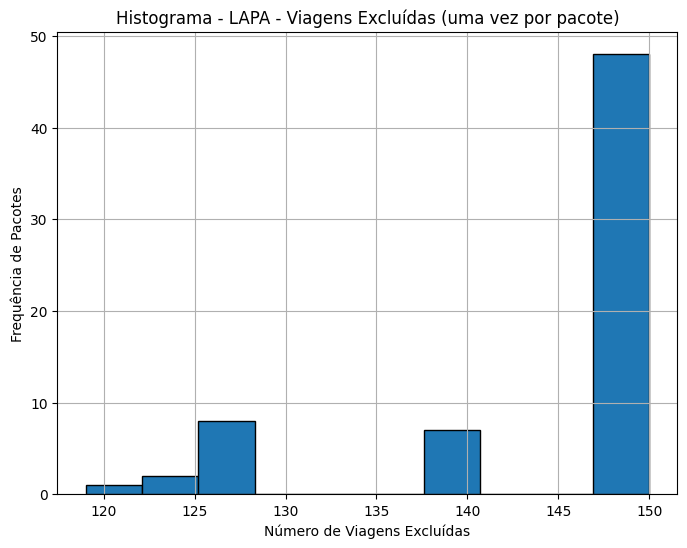

In [6]:

# Produzir um histograma da coluna Viagens excluidas
# Garante que estamos pegando um valor único por pacote
df_por_pacote = df_concatenado.groupby('Pacote')['Viagens excluidas'].first().reset_index()

# Plot do histograma
plt.figure(figsize=(8, 6))
plt.hist(df_por_pacote['Viagens excluidas'], bins=10, edgecolor='black')

plt.title(f'Histograma - {subprefeitura_desejada} - Viagens Excluídas (uma vez por pacote)')
plt.xlabel('Número de Viagens Excluídas')
plt.ylabel('Frequência de Pacotes')
plt.grid(True)

plt.show()



### Obtenção da informação de chuva

In [7]:
# Indicador numérico dos postos:
postos = [503, 1000866, 495, 1000840, 1000854, 1000850, 1000852, 634, 592, 846, 507, 1000300, 1000860, 1000887, 1000859, 524, 1000864, 1000844, 1000862, 1000882, 1000635, 1000842, 1000848, 504, 515, 509, 1000944, 540, 510, 400, 1000876]

# Dados fornecidos (reutilizados):
names = [
    "Sé - CGE (PMSP/SE-01)", "Sé - Anhembi (PMSP/SE-02)", "Vila Mariana (PMSP/VM-01)", 
    "Ipiranga (PMSP/IP-01)", "Campo Limpo (PMSP/CL-03)", "M Boi Mirim (PMSP/MB-01)", 
    "Santo Amaro (PMSP/SA-01)", "Jabaquara (PMSP/JA-01)", "Cidade Ademar - (PMSP/AD-01) / São Paulo", 
    "Capela do Socorro (PMSP/CS-01)", "Parelheiros - Barragem (PMSP/PA-01)", 
    "Estação Meteorológica Marsilac", "Mooca (PMSP/MO-01)", "Penha - Rincão (PMSP/PE-01)", 
    "Aricanduva - Vila Formosa (PMSP/AF-02)", "Vila Prudente - (PMSP/VP-01)", "Itaquera (PMSP/IQ-02)", 
    "São Mateus (PMSP/SM-05)", "São Miguel Paulista (PMSP/MP-01)", "Itaim Paulista (PMSP/IT-01)", 
    "Pinheiros (PMSP/PI-01)", "Butantã (PMSP/BT-02)", "Lapa (PMSP/LA-01)", "Perus (PMSP/PR-01)", 
    "Pirituba (PMSP/PJ-01)", "Freguesia do Ó (PMSP/FO-01)", "Tremembé (PMSP/JT-01)", 
    "Vila Maria - Vila Guilherme (PMSP/MG-01)", "Santana/Tucuruvi - COMDEC (PMSP/ST-01)", 
    "Riacho Grande", "Mauá - Paço Municipal"
]

# Exemplo de lista adicional de estações:
estacoes = ['0', '1', '2', '3', '4', '5','6','7','8','9','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27','28','30','31']

# Índices
indices = list(range(len(names)))

# Criar dicionário com o formato {index: {name, estacao, posto}}
dicionario_estacoes = {
    i: {'Name': names[i], 'Estacao': estacoes[i], 'Posto': postos[i]} 
    for i in indices
}

# Exibir o dicionário
dicionario_estacoes

{0: {'Name': 'Sé - CGE (PMSP/SE-01)', 'Estacao': '0', 'Posto': 503},
 1: {'Name': 'Sé - Anhembi (PMSP/SE-02)', 'Estacao': '1', 'Posto': 1000866},
 2: {'Name': 'Vila Mariana (PMSP/VM-01)', 'Estacao': '2', 'Posto': 495},
 3: {'Name': 'Ipiranga (PMSP/IP-01)', 'Estacao': '3', 'Posto': 1000840},
 4: {'Name': 'Campo Limpo (PMSP/CL-03)', 'Estacao': '4', 'Posto': 1000854},
 5: {'Name': 'M Boi Mirim (PMSP/MB-01)', 'Estacao': '5', 'Posto': 1000850},
 6: {'Name': 'Santo Amaro (PMSP/SA-01)', 'Estacao': '6', 'Posto': 1000852},
 7: {'Name': 'Jabaquara (PMSP/JA-01)', 'Estacao': '7', 'Posto': 634},
 8: {'Name': 'Cidade Ademar - (PMSP/AD-01) / São Paulo',
  'Estacao': '8',
  'Posto': 592},
 9: {'Name': 'Capela do Socorro (PMSP/CS-01)', 'Estacao': '9', 'Posto': 846},
 10: {'Name': 'Parelheiros - Barragem (PMSP/PA-01)',
  'Estacao': '10',
  'Posto': 507},
 11: {'Name': 'Estação Meteorológica Marsilac',
  'Estacao': '11',
  'Posto': 1000300},
 12: {'Name': 'Mooca (PMSP/MO-01)', 'Estacao': '12', 'Posto': 1

In [8]:
def listar_csv_chuva(diretorio):
    arquivos_csv = []
    
    # Percorre os arquivos no diretório fornecido
    for arquivo in os.listdir(diretorio):
        # Verifica se o arquivo tem extensão .csv
        # Reparar que os dados estão filtrados
        if arquivo.endswith(".csv"):
            arquivos_csv.append(arquivo)
                
    return arquivos_csv
    
def buscar_estacao_por_posto(dicionario, posto_desejado):
    for info in dicionario.values():
        if info['Posto'] == posto_desejado:
            return info['Estacao']
        else:
            print(f'O posto {posto_desejado} não foi encontrado')
    return "Posto não encontrado"

import os
import pandas as pd
from glob import glob

# Função para processar um único arquivo CSV
def processar_arquivo_chuva(arquivo_chuva):
    # Carregar o CSV
    df_chuva_10min = pd.read_csv(arquivo_chuva, sep=',')
    
    # Verificar se o DataFrame não está vazio
    if df_chuva_10min.empty:
        print(f"Arquivo {arquivo_chuva} está vazio. Pulando.")
        return None
    
    # Selecionar as colunas relevantes
    df_chuva_10min = df_chuva_10min.loc[:, ['DATA', 'Posto', 'PLU(mm)']]
    
    # Converter os valores da coluna 'PLU(mm)' de mm/h para m/h
    #df_chuva_10min = converter_mm_para_m(df_chuva_10min, 'PLU(mm)')

    # Converter a coluna 'DATA' para datetime
    df_chuva_10min['DATA'] = pd.to_datetime(df_chuva_10min['DATA'])
    
    # Filtrar pelos meses desejados 
    meses_desejados = [1, 2, 3]  # Janeiro, Fevereiro e Março
    df_chuva_10min = df_chuva_10min[df_chuva_10min['DATA'].dt.month.isin(meses_desejados)]
    
     # Verificar se o DataFrame ainda contém dados após o filtro
    if df_chuva_10min.empty:
        print(f"Nenhum dado relevante nos meses desejados no arquivo {arquivo_chuva}. Pulando.")
        return None
    
    # Definir a coluna 'DATA' como índice
    df_chuva_10min.set_index('DATA', inplace=True)
    
    # Somar os valores de 'PLU(mm)' a cada hora e criar um novo DataFrame com os dados agregados
    df_chuva_hora = df_chuva_10min['PLU(mm)'].resample('h').sum().to_frame()
    
    # Capturar o número do posto (assumindo que é o mesmo para todas as linhas)
    numero_posto = df_chuva_10min['Posto'].iloc[0]
    if numero_posto == 400:
        print('Achei um dos perdidos! ', numero_posto)
        
    # Excluir a coluna 'Posto'
    df_chuva_10min.drop(columns=['Posto'], inplace=True)
    
    # Renomear a coluna 'PLU(mm)' para incluir o número do posto
    estacao = buscar_estacao_por_posto(dicionario_estacoes, numero_posto)
    df_chuva_hora.rename(columns={'PLU(mm)': estacao}, inplace=True)
    
    # Criar novas colunas 'Dia' e 'Hora' com base no índice
    df_chuva_hora['Dia'] = df_chuva_hora.index.date
    df_chuva_hora['Hora'] = df_chuva_hora.index.time
    
    return df_chuva_hora
    
def converter_mm_para_m(df, nome_coluna):
    # De acordo com as informações encontradas no tutorial do SynxFlow, os dados de chuva
    # deverão ser inseridos como m/h: 
    # https://synxflow.readthedocs.io/en/latest/Tutorials/flood.html
    # The other columns are the rainfall intensity values (in meter per second) for cells with rain mask indices starting from 0
    # Verificar se a coluna existe no DataFrame
    if nome_coluna in df.columns:
        # Converter os valores de mm/h para m/h
        df[nome_coluna] = df[nome_coluna] / 1000
        # Não tenho certeza, mas me parece ser necessário dividir por 3600, passando de segundo para hora:
        df[nome_coluna] = df[nome_coluna] / 3600
    else:
        print(f"Coluna '{nome_coluna}' não encontrada no DataFrame.")
    
    return df

# Função para processar todos os arquivos CSV em um diretório
def processar_todos_arquivos_chuva(diretorio):
    # Encontrar todos os arquivos CSV no diretório
    arquivos_csv = glob(os.path.join(diretorio, '*.csv'))
    
    # Criar uma lista para armazenar os DataFrames processados
    dfs_processados = []
    
    # Iterar sobre todos os arquivos CSV
    for arquivo in arquivos_csv:
        print(f"Processando {arquivo}...")
        df_processado = processar_arquivo_chuva(arquivo)
        if df_processado is not None:
            dfs_processados.append(df_processado)
    
    # Concatenar todos os DataFrames processados (usando join para garantir alinhamento por 'DATA')
    df_final = pd.concat(dfs_processados, axis=1, join='outer')
    
    # Remover possíveis duplicatas no índice
    df_final = df_final[~df_final.index.duplicated(keep='first')]
    
    # Remover colunas desnecessárias (mantendo apenas 'DATA' e os valores de PLU)
    colunas_a_remover = [col for col in df_final.columns if 'Dia' in col or 'Hora' in col]
    df_final = df_final.drop(columns=colunas_a_remover)
    
    # Identificar a primeira coluna como coluna de data, assumindo que seja a primeira coluna do DataFrame
    primeira_coluna = df_final.columns[0]  # Obtenha o nome da primeira coluna

    # Excluir colunas com o título 'Posto não encontrado'
    df_final = df_final.loc[:, ~df_final.columns.str.contains('Posto não encontrado')]

    # Adiciona uma coluna 1 com valores zerados
    df_final.loc[:,'1'] = 0

    # Adiciona uma coluna 29 com valores zerados, já que esse pluviometro está localizado em Santana do Parnaíba (fora dos limites do munícipio de São Paulo)
    df_final.loc[:,'29'] = 0

    # Ordenar as colunas numéricas em ordem crescente
    colunas_numericas = sorted([col for col in df_final.columns if col.isnumeric()], key=int)

    # Verificar se a primeira coluna é de datas ou texto e organizar a ordem
    if primeira_coluna not in colunas_numericas:
        # Colocar a primeira coluna (DATA) antes das colunas numéricas ordenadas
        df_final = df_final[[primeira_coluna] + colunas_numericas]
    else:
        # Caso contrário, apenas reordena as colunas numéricas
        df_final = df_final[colunas_numericas]

    df_final = adicionar_indexador(df_final)
    
    # Pegando todas as colunas do DataFrame
    colunas = df_final.columns.tolist()
    
    # Movendo a coluna 'indexador' para ser a segunda
    colunas.remove('indexador')
    nova_ordem = ['indexador'] + colunas

    # Reordenando o DataFrame
    df_final = df_final[nova_ordem]

    return df_final

def adicionar_indexador(df):
    # Cria uma coluna 'indexador' começando em 0 e incrementando 3600 a cada linha
    df['indexador'] = range(0, len(df) * 3600, 3600)
    return df

In [9]:
df_final_2023 = processar_todos_arquivos_chuva(diretório_chuva)

# Verificar as primeiras linhas do DataFrame final
df_final_2023

Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/meteorologicas_2023/dados_cge___P524_Vila_Prudente____PMSP_VP_01_.csv...
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
O posto 524 não foi encontrado
Processando /Users/marcelofernandes/Library/CloudStorage/GoogleDrive-marcelo.fernandes@alumni.usp.br/.shortcut-targets-by-id/1M--OnzbTYagrNv5Ss9fjWlBxCMmasz-Y/10_Mestrado_2021_Marcelo Fernandes/8_Dados/estações_meteorológicas/mete

,indexador,0,1,2,3,4,5,6,7,8,...,22,23,24,25,26,27,28,29,30,31
DATA,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:00:00,0,2.256,0,4.700,0.564,3.384,0.940,124.340,118.046,0.000,...,4.512,1.692,123.665,0.752,0.0,117.744,2.820,0,0.376,0.0
2023-01-01 01:00:00,3600,1.504,0,6.768,0.000,2.256,1.692,122.961,116.223,0.000,...,3.384,0.188,121.983,0.000,0.0,118.610,5.828,0,0.752,0.0
2023-01-01 02:00:00,7200,3.948,0,7.520,0.000,2.444,2.444,122.457,117.503,0.376,...,1.692,0.564,123.242,0.188,0.0,119.123,1.316,0,0.752,0.0
2023-01-01 03:00:00,10800,4.136,0,10.152,0.000,2.444,3.196,122.235,118.328,3.008,...,4.888,0.000,120.021,0.000,0.0,116.959,7.708,0,1.880,0.0
2023-01-01 04:00:00,14400,0.940,0,7.144,1.504,2.444,0.940,120.573,114.943,0.000,...,2.068,0.000,117.039,0.000,0.0,113.112,4.136,0,4.888,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-31 19:00:00,7758000,0.000,0,3.008,0.000,1.316,4.136,134.623,130.996,3.384,...,5.264,5.452,134.482,0.000,0.0,122.477,3.384,0,0.752,0.0
2023-03-31 20:00:00,7761600,2.256,0,2.632,0.000,1.692,0.000,136.850,132.982,0.000,...,5.640,1.128,141.572,0.000,0.0,125.730,9.588,0,1.316,0.0
2023-03-31 21:00:00,7765200,2.820,0,3.008,0.000,3.760,2.444,135.096,128.561,1.316,...,3.384,2.444,136.527,0.000,0.0,124.823,9.024,0,0.000,0.0


In [10]:
import pandas as pd
import re

def obter_info_simulacao(pacotes, pacote_num):
    """
    Retorna informações de hora e data de simulação a partir do número do pacote.
    
    Parâmetros:
    - pacotes: caminho para o arquivo Excel contendo os dados
    - pacote_num: string do tipo 'Pacote_38'

    Retorna:
    - dict com chaves: 'hora_inicial', 'hora_final', 'data_inicial', 'data_final'
    """
    # Carrega os dados
    df_pacotes = pd.read_excel(pacotes)
    
    # Extrai o número do pacote
    numero_extraido = re.search(r'\d+', pacote_num).group()
    numero_com_ponto = float(int(numero_extraido))

    # Localiza a linha correspondente
    linha_pacote = df_pacotes[df_pacotes['Pacote'] == numero_com_ponto]

    if linha_pacote.empty:
        raise ValueError(f'Pacote número {numero_com_ponto} não encontrado no arquivo.')

    # Extrai e formata os dados
    return {
        'hora_inicial': linha_pacote['Simulação Início'].values[0],
        'hora_final': linha_pacote['Simulação Final'].values[0],
        'data_inicial': pd.to_datetime(linha_pacote['Data_Simul_Ini'].values[0]).date(),
        'data_final': pd.to_datetime(linha_pacote['Data_Simul_Fim'].values[0]).date(),
    }


In [30]:
info = obter_info_simulacao(pacotes, 'Pacote_01')
print(info['hora_inicial'])
print(info['data_inicial'])


04:25:00
2023-02-01


### Polígono de chuvas

In [12]:
# Carregar o arquivo CSV com as subprefeituras selecionadas
df_subprefeituras = pd.read_csv("resultados_ordenados_alagamentos.csv")

# Selecionar as 10 subprefeituras com maior índice de alagamento
df_sp_lista = df_subprefeituras.sort_values(by="Média", ascending=False).head(10)
#TODO Explicar bem esse critério dentro do capítulo de método

# Carregar o shapefile das subprefeituras
gdf = gpd.read_file(subprefeituras_shp)

# Filtrar o GeoDataFrame para manter apenas as subprefeituras da lista
gdf_sp_filtrado = gdf[gdf["sp_nome"].isin(df_sp_lista["sp_nome"])]

# Salvar em disco (GeoPackage e Parquet)
#bbox_gdf.to_file("bounding_boxes.gpkg", driver="GPKG")
#bbox_gdf.to_parquet("bounding_boxes.parquet")

print("Bounding boxes geradas com sucesso!")

# Define the UTM Zone 23S coordinate system
utm_crs = CRS("EPSG:31983")  # UTM Zone 23S, southern hemisphere

# Atribuição do esquema de projeção
gdf_sp_filtrado = gdf_sp_filtrado.set_crs(utm_crs)

# Verificar o CRS atual
print("CRS Atual:", gdf_sp_filtrado.crs)


Bounding boxes geradas com sucesso!
CRS Atual: EPSG:31983


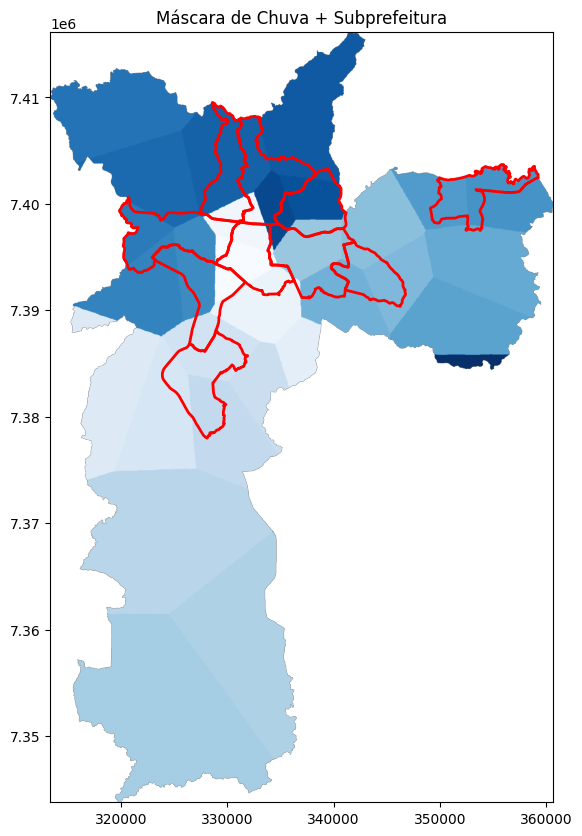

In [13]:
from rasterio.plot import show

# Abrir o raster e plotar
with rasterio.open(raster_poligono_chuva) as src:
    fig, ax = plt.subplots(figsize=(10, 10))

    # Mostrar o raster
    show(src, ax=ax, cmap='Blues')

    # Mostrar a subprefeitura (com borda e preenchimento transparente)
    gdf_sp_filtrado.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=2)

    ax.set_title('Máscara de Chuva + Subprefeitura')
    plt.show()

In [14]:
# Lista de resultados
resultados = []

for idx, row in gdf_sp_filtrado.iterrows():
    nome_sub = row['sp_nome']  # ajuste conforme a sua coluna
    geom = [row['geometry']]

    with rasterio.open(raster_poligono_chuva) as src:
        out_image, out_transform = mask(src, geom, crop=True)
        nodata =  src.nodata
    
    dados = out_image[0]

    # Máscara para excluir nodata
    if nodata is not None:
        dados = dados[dados != nodata]
    else:
        dados = dados[~np.isnan(dados)]

    area_total_pixels = dados.size  # total de pixels válidos (não é m², é nº de pixels)

    # Contar pixels por valor
    valores, contagens = np.unique(dados, return_counts=True)

    for val, count in zip(valores, contagens):
        percentual = (count / area_total_pixels) * 100

        resultados.append({
            'Subprefeitura': nome_sub,
            'Estação Meteorológica': int(val),
            'Percentual da Área (%)': round(percentual, 1)
        })

# Criar o DataFrame com os resultados
df_final = pd.DataFrame(resultados)

# Exibir tudo (ajustável conforme a necessidade)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df_final)

                Subprefeitura  Estação Meteorológica  Percentual da Área (%)
0     CASA VERDE-CACHOEIRINHA                      1                    19.4
1     CASA VERDE-CACHOEIRINHA                     25                    80.6
2                        LAPA                      0                     5.8
3                        LAPA                      1                     9.4
4                        LAPA                     20                    28.3
5                        LAPA                     21                    12.7
6                        LAPA                     22                    35.1
7                        LAPA                     24                     8.3
8                        LAPA                     25                     0.4
9                          SE                      0                    46.1
10                         SE                      1                    27.1
11                         SE                      2                    24.1

In [15]:
# Criar um dicionário de referência rápido: valor_raster -> nome estação
map_valor_para_nome = {
    k: v['Name'] for k, v in dicionario_estacoes.items()
}

# Agora, adicionar a coluna com o nome da estação no df_final
df_final['Estação'] = df_final['Estação Meteorológica'].map(map_valor_para_nome)

# Agrupar por subprefeitura e exibir os resultados
subprefeituras = df_final['Subprefeitura'].unique()

for sub in subprefeituras:
    print(f"\nSubprefeitura: {sub}")
    dados_sub = df_final[df_final['Subprefeitura'] == sub]
    
    for _, linha in dados_sub.iterrows():
        nome_estacao = linha['Estação']
        percentual = linha['Percentual da Área (%)']
        print(f" - Estação: {nome_estacao}, Percentual: {percentual:.1f}%")



Subprefeitura: CASA VERDE-CACHOEIRINHA
 - Estação: Sé - Anhembi (PMSP/SE-02), Percentual: 19.4%
 - Estação: Freguesia do Ó (PMSP/FO-01), Percentual: 80.6%

Subprefeitura: LAPA
 - Estação: Sé - CGE (PMSP/SE-01), Percentual: 5.8%
 - Estação: Sé - Anhembi (PMSP/SE-02), Percentual: 9.4%
 - Estação: Pinheiros (PMSP/PI-01), Percentual: 28.3%
 - Estação: Butantã (PMSP/BT-02), Percentual: 12.7%
 - Estação: Lapa (PMSP/LA-01), Percentual: 35.1%
 - Estação: Pirituba (PMSP/PJ-01), Percentual: 8.3%
 - Estação: Freguesia do Ó (PMSP/FO-01), Percentual: 0.4%

Subprefeitura: SE
 - Estação: Sé - CGE (PMSP/SE-01), Percentual: 46.1%
 - Estação: Sé - Anhembi (PMSP/SE-02), Percentual: 27.1%
 - Estação: Vila Mariana (PMSP/VM-01), Percentual: 24.1%
 - Estação: Mooca (PMSP/MO-01), Percentual: 1.5%
 - Estação: Santana/Tucuruvi - COMDEC (PMSP/ST-01), Percentual: 1.3%

Subprefeitura: SANTANA-TUCURUVI
 - Estação: Sé - Anhembi (PMSP/SE-02), Percentual: 9.5%
 - Estação: Freguesia do Ó (PMSP/FO-01), Percentual: 38.5

### Área horária de resiliência / Chuva horária na subprefeitura

In [16]:
# Filtrando somente o pacote de interesse
resiliencia_df = df_concatenado[df_concatenado['Pacote'] == 'Pacote_01']
print(resiliencia_df)
nome_sp = subprefeitura_desejada

       Pacote Subprefeitura             coluna  tt_chuva  tt_seco_mod  \
0   Pacote_01          LAPA  tt_pct1_h_2736000  5.671769     4.399798   
1   Pacote_01          LAPA  tt_pct1_h_2743200  5.907343     4.399798   
2   Pacote_01          LAPA  tt_pct1_h_2710800  5.264062     4.399798   
3   Pacote_01          LAPA  tt_pct1_h_2692800  4.399798     4.399798   
4   Pacote_01          LAPA  tt_pct1_h_2721600  5.435388     4.399798   
5   Pacote_01          LAPA  tt_pct1_h_2728800  5.572887     4.399798   
6   Pacote_01          LAPA  tt_pct1_h_2707200  5.245206     4.399798   
7   Pacote_01          LAPA  tt_pct1_h_2761200  5.553282     4.399798   
8   Pacote_01          LAPA  tt_pct1_h_2703600  5.292407     4.399798   
9   Pacote_01          LAPA  tt_pct1_h_2739600  5.852232     4.399798   
10  Pacote_01          LAPA  tt_pct1_h_2718000  5.368135     4.399798   
11  Pacote_01          LAPA  tt_pct1_h_2732400  5.609291     4.399798   
12  Pacote_01          LAPA  tt_pct1_h_2754000  5.7

In [20]:
len(resiliencia_df)

22

In [17]:
from datetime import datetime, timedelta, time
import pandas as pd

def ajustar_horario(hora):
    """Converte timedelta para time, se necessário."""
    if isinstance(hora, timedelta):
        return (datetime.min + hora).time()
    elif isinstance(hora, time):
        return hora
    else:
        raise TypeError("Hora deve ser do tipo timedelta ou time.")

def arredondar_para_proxima_hora(hora_dt):
    """Arredonda para a próxima hora cheia, se necessário."""
    if hora_dt.minute > 0 or hora_dt.second > 0:
        return (hora_dt + timedelta(hours=1)).replace(minute=0, second=0, microsecond=0)
    return hora_dt

def filtrar_por_periodo_simulacao(df, data_inicial, hora_inicial, data_final, hora_final):
    """
    Filtra o DataFrame entre a combinação de data/hora inicial e final, ajustando os formatos.

    Parâmetros:
    - df: DataFrame com índice datetime
    - data_inicial, data_final: strings ou datetime.date
    - hora_inicial, hora_final: timedelta ou time

    Retorna:
    - DataFrame filtrado
    """
    # Converte datas
    data_inicial = pd.to_datetime(data_inicial).date()
    data_final = pd.to_datetime(data_final).date()

    # Corrige horas
    hora_ini = ajustar_horario(hora_inicial)
    hora_fim = ajustar_horario(hora_final)

    # Combina em datetime
    dt_ini = datetime.combine(data_inicial, hora_ini)
    dt_fim = datetime.combine(data_final, hora_fim)
    dt_fim_corrigido = arredondar_para_proxima_hora(dt_fim)

    # Filtra
    return df.loc[(df.index >= dt_ini) & (df.index <= dt_fim_corrigido)]


In [33]:
df_chuva_periodo = filtrar_por_periodo_simulacao(
    df_final_2023,
    data_inicial=info['data_inicial'],
    hora_inicial=info['hora_inicial'],
    data_final=info['data_final'],
    hora_final=info['hora_final']
)
#print(df_chuva_periodo)

Tamanho de tempo: 21
Tamanho de tt_chuva: 22
Tamanho de tt_seco_mod: 22


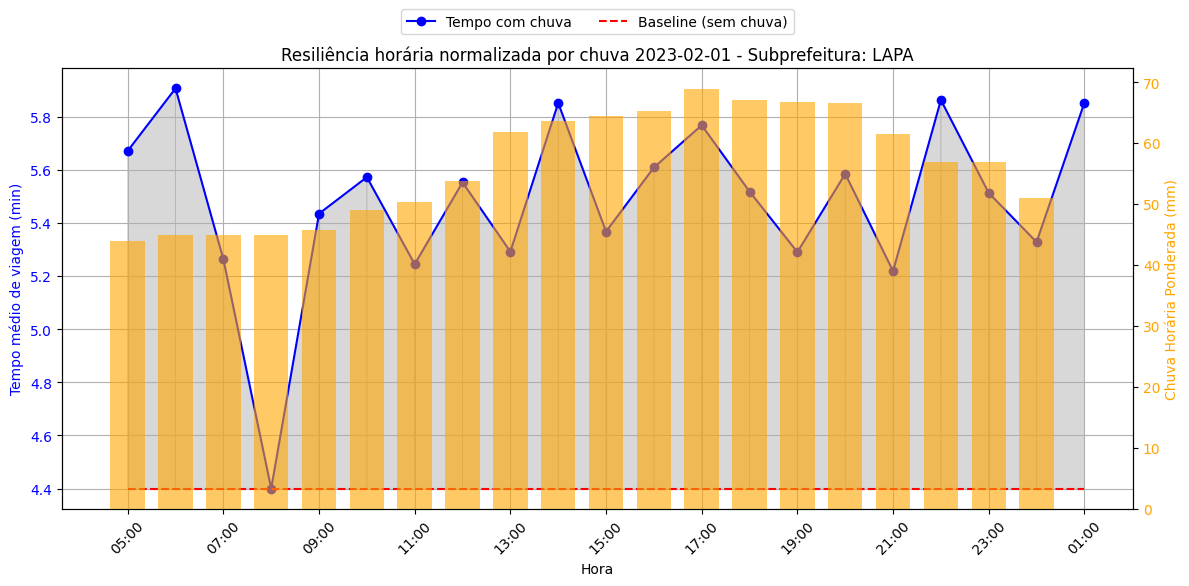


✅ Área total normalizada por chuva horária: 0.38 min·hora/mm


In [34]:
# Preparar os dados
tempo = df_chuva_periodo.index.to_numpy()
print(f'Tamanho de tempo: {len(tempo)}')
tt_chuva = resiliencia_df['tt_chuva'].values
print(f'Tamanho de tt_chuva: {len(tt_chuva)}')
tt_seco_mod = resiliencia_df['tt_seco_mod'].values
print(f'Tamanho de tt_seco_mod: {len(tt_seco_mod)}')
data_formatada = info['data_inicial']

indices_normalizados = []
chuva_ponderada_por_hora = []
area_resiliencia_normalizada = 0

min_len = min(len(tempo), len(tt_chuva), len(tt_seco_mod))

tempo = tempo[:min_len]
tt_chuva = tt_chuva[:min_len]
tt_seco_mod = tt_seco_mod[:min_len]

# Criar mapa de estações para a subprefeitura
dados_sp = df_final[df_final['Subprefeitura'] == nome_sp]
percentuais_estacoes = {}
for _, linha in dados_sp.iterrows():
    estacao_nome = linha['Estação']
    percentual = linha['Percentual da Área (%)']
    for idx, dados in dicionario_estacoes.items():
        if dados['Name'] == estacao_nome:
            estacao_id = dados['Estacao']
            percentuais_estacoes[estacao_id] = percentual
            break

# Iniciar gráfico
fig, ax1 = plt.subplots(figsize=(12, 6))
ax1.plot(tempo, tt_chuva, marker='o', linestyle='-', color='b', label='Tempo com chuva')
ax1.plot(tempo, tt_seco_mod, linestyle='--', color='r', label='Baseline (sem chuva)')

# Loop principal: calcular e plotar
for i in range(len(tempo) - 1):
    x_trap = [tempo[i], tempo[i], tempo[i+1], tempo[i+1]]
    y_trap = [tt_seco_mod[i], tt_chuva[i], tt_chuva[i+1], tt_seco_mod[i+1]]
    base1 = abs(tt_chuva[i] - tt_seco_mod[i])
    base2 = abs(tt_chuva[i+1] - tt_seco_mod[i+1])
    area = 0.5 * (base1 + base2)

    # Chuva ponderada na hora i
    chuva_hora = df_chuva_periodo.iloc[i]
    chuva_ponderada = sum(chuva_hora.get(est_id, 0) * pct / 100 for est_id, pct in percentuais_estacoes.items())
    chuva_ponderada_por_hora.append(chuva_ponderada)

    indice = area / chuva_ponderada if chuva_ponderada > 0 else 0
    indices_normalizados.append(indice)
    area_resiliencia_normalizada += indice

    # Desenhar o trapézio
    ax1.fill(x_trap, y_trap, color='gray', alpha=0.3, edgecolor='gray', linewidth=0.5)


# Ajustar eixo primário
ax1.set_title(f'Resiliência horária normalizada por chuva {data_formatada} - Subprefeitura: {nome_sp}')
ax1.set_xlabel('Hora')
ax1.set_ylabel('Tempo médio de viagem (min)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.legend(loc='upper left')
ax1.grid(True)
plt.xticks(rotation=45)

# Mostrar apenas a hora no eixo X
ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))  # Mostra de 2 em 2h
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

# Eixo secundário: chuva horária
ax2 = ax1.twinx()
ax2.bar(tempo[:len(chuva_ponderada_por_hora)], chuva_ponderada_por_hora, 
        width=0.03, color='orange', alpha=0.6, label='Chuva Horária')
ax2.set_ylabel('Chuva Horária Ponderada (mm)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Legenda e mostrar
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
#ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)


plt.tight_layout()
plt.show()

print(f"\n✅ Área total normalizada por chuva horária: {area_resiliencia_normalizada:.2f} min·hora/mm")


🔄 Calculando resiliência por pacote: 100%|██████████| 66/66 [00:01<00:00, 45.65it/s]


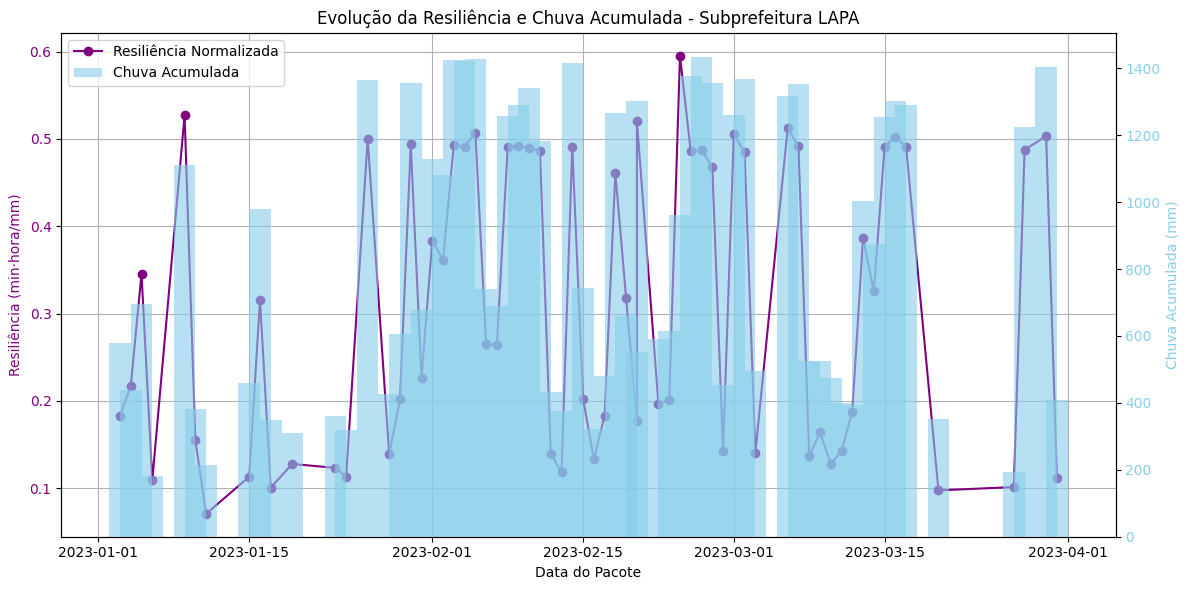

In [39]:
from tqdm import tqdm
import matplotlib.pyplot as plt

# Lista para armazenar os resultados
resiliencia_por_pacote = []
chuva_total_por_pacote = []

lista_de_pacotes = df_concatenado['Pacote'].unique()

# Iterar sobre os pacotes com barra de progresso
for nome_pacote in tqdm(lista_de_pacotes, desc="🔄 Calculando resiliência por pacote"):

    info = obter_info_simulacao(pacotes, nome_pacote)
    df_chuva_periodo = filtrar_por_periodo_simulacao(
        df_final_2023,
        data_inicial=info['data_inicial'],
        hora_inicial=info['hora_inicial'],
        data_final=info['data_final'],
        hora_final=info['hora_final']
    )
    resiliencia_df = df_concatenado[df_concatenado['Pacote'] == nome_pacote]
    data_formatada = pd.to_datetime(info['data_inicial'])

    tempo = df_chuva_periodo.index.to_numpy()
    tt_chuva = resiliencia_df['tt_chuva'].values
    tt_seco_mod = resiliencia_df['tt_seco_mod'].values

    min_len = min(len(tempo), len(tt_chuva), len(tt_seco_mod))
    tempo = tempo[:min_len]
    tt_chuva = tt_chuva[:min_len]
    tt_seco_mod = tt_seco_mod[:min_len]

    dados_sp = df_final[df_final['Subprefeitura'] == nome_sp]
    percentuais_estacoes = {
        dados['Estacao']: linha['Percentual da Área (%)']
        for _, linha in dados_sp.iterrows()
        for idx, dados in dicionario_estacoes.items()
        if dados['Name'] == linha['Estação']
    }

    area_resiliencia_normalizada = 0
    chuva_acumulada = 0

    for i in range(len(tempo) - 1):
        base1 = abs(tt_chuva[i] - tt_seco_mod[i])
        base2 = abs(tt_chuva[i+1] - tt_seco_mod[i+1])
        area = 0.5 * (base1 + base2)

        chuva_hora = df_chuva_periodo.iloc[i]
        chuva_ponderada = sum(chuva_hora.get(est_id, 0) * pct / 100 for est_id, pct in percentuais_estacoes.items())
        indice = area / chuva_ponderada if chuva_ponderada > 0 else 0

        area_resiliencia_normalizada += indice
        chuva_acumulada += chuva_ponderada

    resiliencia_por_pacote.append((data_formatada, area_resiliencia_normalizada))
    chuva_total_por_pacote.append((data_formatada, chuva_acumulada))

# Ordenar por data
resiliencia_por_pacote.sort(key=lambda x: x[0])
chuva_total_por_pacote.sort(key=lambda x: x[0])

# Separar valores
datas, resiliencias = zip(*resiliencia_por_pacote)
_, chuvas = zip(*chuva_total_por_pacote)

# 📊 Plotar gráfico com eixo duplo
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eixo 1: Resiliência
ax1.plot(datas, resiliencias, color='purple', marker='o', label='Resiliência Normalizada')
ax1.set_xlabel('Data do Pacote')
ax1.set_ylabel('Resiliência (min·hora/mm)', color='purple')
ax1.tick_params(axis='y', labelcolor='purple')
ax1.grid(True)
ax1.set_title(f'Evolução da Resiliência e Chuva Acumulada - Subprefeitura {nome_sp}')

# Eixo 2: Chuva
ax2 = ax1.twinx()
ax2.bar(datas, chuvas, color='skyblue', alpha=0.6, width=2, label='Chuva Acumulada')
ax2.set_ylabel('Chuva Acumulada (mm)', color='skyblue')
ax2.tick_params(axis='y', labelcolor='skyblue')

# Legenda combinada
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
